### Edgar Moises Hernandez-Gonzalez
#### 30/04/20-24/05/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D
##### Caracteristicas = Espectrogramas STFFT (3D)
##### Concatenacion vertical
##### Resize proporcional de (11 x n_canales / 2) x 10 [176x10] o [66x10]
##### Validacion cruzada

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (f1_score, confusion_matrix,
                             roc_auc_score, roc_curve)
from scipy.signal import spectrogram
# import cv2
# from keras.utils import to_categorical
# from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
# from keras.callbacks import ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [2]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [3]:
# todos los canales
# x = pd.read_csv("../Datos/MeCa15RMFH-3.csv", header=None)

# centrales y parietales
# x = pd.read_csv("../Datos/MeCaCenPar15RMFH-3.csv", header=None)

# ventaneo
x = pd.read_csv("../Datos/VentaneoMC-15-3.csv", header=None)

# etiquetas
# y = pd.read_csv("../Datos/EtiquetasMeCa01ACLL-01.csv", header=None).values

# etiquetas ventaneo
y = pd.read_csv("../Datos/EtiquetasVenta-15-3.csv", header=None).values

In [4]:
print(x.shape)
print(y.shape)

(2128, 32768)
(2128, 1)


In [5]:
n_samples = len(y) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples:", n_samples)

n_samples: 2128


In [6]:
n_classes = len(np.unique(y)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 2


In [8]:
# las etiquetas en categorical para poder entrenar data augmentation
# y_categorical = to_categorical(y)

In [ ]:
#unir 32 canales y resize de tamaño proporcional
def unir_espectrogramas_vertical_todo(data):
  dim = (5, 352) #ancho, alto
  fs = 512
  datos = np.zeros((data.shape[0],352,5))
  temporal = np.zeros((352,5))
  for i in range(data.shape[0]): #n muestras
    for j in range(32): #32 canales
      sig = data.iloc[i, j*1344:(j+1)*1344]
      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
      temporal[j*11:(j+1)*11, :] = Sxx[4:15, :]
    #resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = temporal
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [9]:
#unir 12 canales (centrales y parietales) y resize de tamaño proporcional
'''def unir_espectrogramas_vertical_resize_cp(data):
  dim = (10, 66) #ancho, alto
  fs = 512
  datos = np.zeros((data.shape[0],66,10))
  temporal = np.zeros((132,5))
  for i in range(data.shape[0]): #n muestras
    for j in range(12): #12 canales, centrales y parietales
      sig = data.iloc[i, j*1344:(j+1)*1344]
      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
      temporal[j*11:(j+1)*11, :] = Sxx[4:15, :]
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos'''

In [7]:
#unir 32 canales y resize de tamaño proporcional
def unir_espectrogramas_vertical_todo_ventaneo(data):
  dim = (4, 352) #ancho, alto
  fs = 512
  datos = np.zeros((data.shape[0],352,4))
  temporal = np.zeros((352,4))
  for i in range(data.shape[0]): #n muestras
    for j in range(32): #32 canales
      sig = data.iloc[i, j*1024:(j+1)*1024]
      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
      temporal[j*11:(j+1)*11, :] = Sxx[4:15, :]
    #resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = temporal
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [8]:
# llamar a unir_espectrogramas_vertical_resize(data)
# aqui se debe llamar a _todo (32 canales) o a _cp (12 canales)
x = unir_espectrogramas_vertical_todo_ventaneo(x)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100


In [9]:
print(x.shape)

(2128, 352, 4)


In [10]:
print(np.max(x))
print(np.min(x))
print(np.mean(x))

235.89076024832696
4.138054751199334e-08
0.9990277192192556


In [11]:
#convertir a float
x = x.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x /= np.ceil(np.max(x))

In [12]:
print(np.max(x))
print(np.min(x))
print(np.mean(x))

0.9995371
1.7534131e-10
0.004233167


In [13]:
#convertir de 3D a 4D
x = x.reshape((x.shape[0], x.shape[1], x.shape[2], 1))

print(x.shape)

(2128, 352, 4, 1)


In [17]:
# data augmentation
# datagen = ImageDataGenerator(width_shift_range=0.25)

In [14]:
skf = StratifiedKFold(n_splits = 5)

In [15]:
def CNN_2D():
  model = Sequential()
  model.add(Conv2D(16, (3,3), activation='relu', padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
  model.add(MaxPool2D((2,2)))
  #model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
  #model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model


Iteration: 1
loss:  0.8649197310249446
accuracy:  0.8685445785522461
f1: 0.8629595588235294
confusion matrix:
 [[142  13]
 [ 43 228]]
AUC 0.9413879300083324


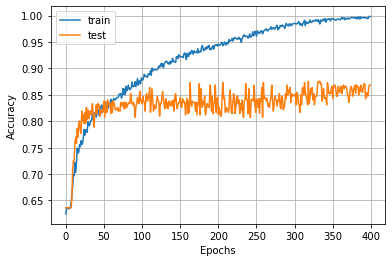

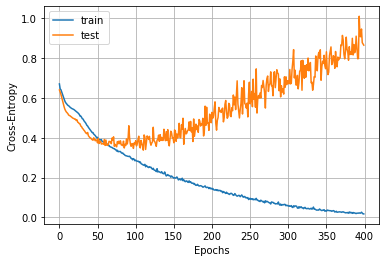


Iteration: 2
loss:  0.7805282337669756
accuracy:  0.7535211443901062
f1: 0.7451964431177975
confusion matrix:
 [[122  34]
 [ 71 199]]
AUC 0.8944919278252612


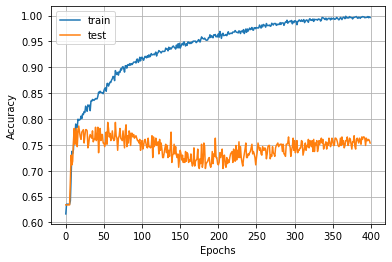

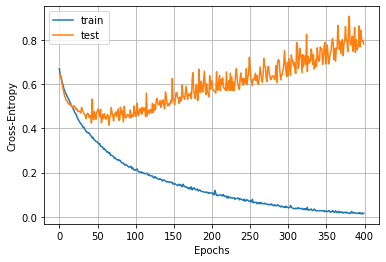


Iteration: 3
loss:  0.48500723587655126
accuracy:  0.8755868673324585
f1: 0.8634508034618106
confusion matrix:
 [[123  33]
 [ 20 250]]
AUC 0.9467592592592593


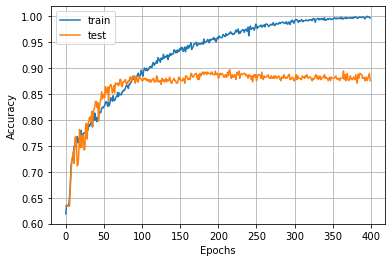

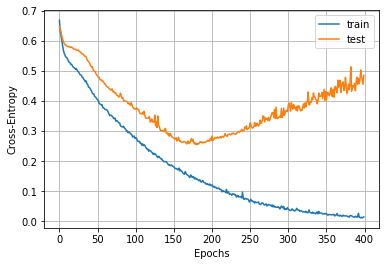


Iteration: 4
loss:  0.847103800773619
accuracy:  0.7976470589637756
f1: 0.7741819889284303
confusion matrix:
 [[101  54]
 [ 32 238]]
AUC 0.8912664277180407


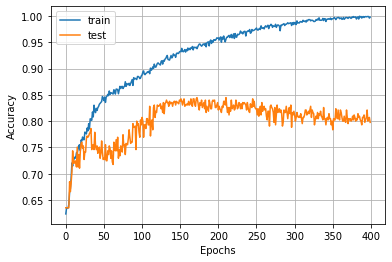

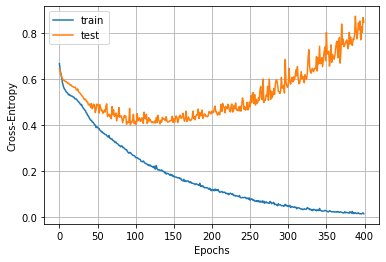


Iteration: 5
loss:  1.3342136192497085
accuracy:  0.7835294008255005
f1: 0.7493204082679388
confusion matrix:
 [[ 88  67]
 [ 25 245]]
AUC 0.8534767025089607


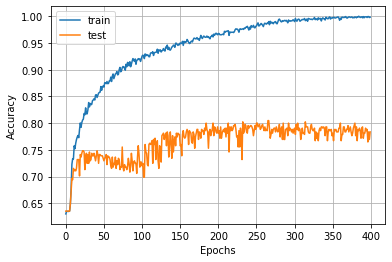

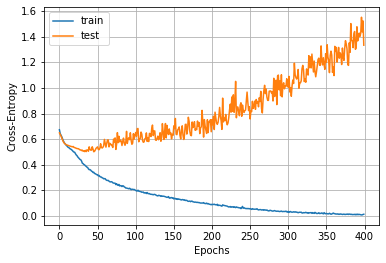


Resultados:
loss: [0.8649197310249446, 0.7805282337669756, 0.48500723587655126, 0.847103800773619, 1.3342136192497085]
accuracy: [0.8685445785522461, 0.7535211443901062, 0.8755868673324585, 0.7976470589637756, 0.7835294008255005]
f1: [0.8629595588235294, 0.7451964431177975, 0.8634508034618106, 0.7741819889284303, 0.7493204082679388]
auc: [0.9413879300083324, 0.8944919278252612, 0.9467592592592593, 0.8912664277180407, 0.8534767025089607]
Tiempo: 1564.8721325397491


In [16]:
inicio = time.time()
array_loss = []
array_acc = []
array_f1 = []
array_auc = []
i = 0
for iTrain, jTest in skf.split(x, y):
  print("\nIteration:", i + 1)
  x_train, x_test = x[iTrain], x[jTest]
  y_train, y_test = y[iTrain], y[jTest]

  model = CNN_2D()
  
  history = model.fit(x_train, y_train, epochs=400, batch_size=20,
                      validation_data=(x_test, y_test), verbose=0)

  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  f1 = f1_score(y_test, y_pred, average='macro')
  array_f1.append(f1)
  print("f1:", f1)
  
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)

  probabilidades = probabilidades[:, 1]
  auc = roc_auc_score(y_test, probabilidades)
  fpr, tpr, thresholds = roc_curve(y_test, probabilidades)
  array_auc.append(auc)

  print("AUC", auc)
  #plt.plot(fpr, tpr)
  #plt.grid()
  #plt.xlabel('False Positive Rate')
  #plt.ylabel('True Positive Rate')
  #plt.show()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
  i += 1
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("f1:", array_f1)
print("auc:", array_auc)
fin = time.time()
print("Tiempo:", fin - inicio)


Iteration: 1
loss:  0.31339767013416914
accuracy:  0.8524590134620667
f1: 0.8383868118928466
confusion matrix:
 [[17  5]
 [ 4 35]]
AUC 0.9335664335664335


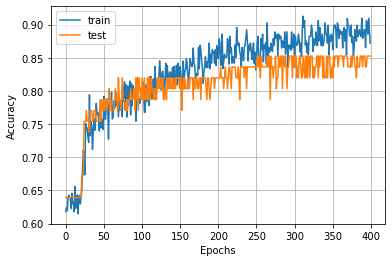

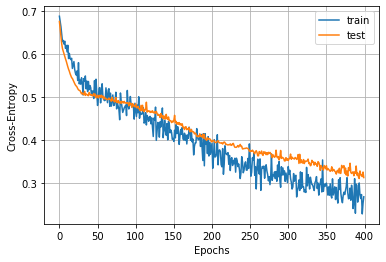


Iteration: 2
loss:  0.19300500364577183
accuracy:  0.9508196711540222
f1: 0.9471861471861471
confusion matrix:
 [[21  1]
 [ 2 37]]
AUC 0.9836829836829837


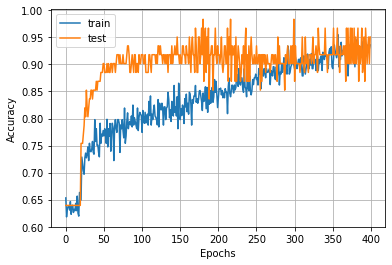

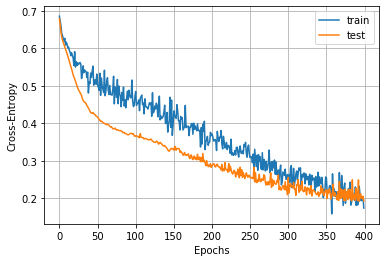


Iteration: 3
loss:  0.31983642744236307
accuracy:  0.8852459192276001
f1: 0.8788652482269504
confusion matrix:
 [[20  2]
 [ 5 34]]
AUC 0.9312354312354313


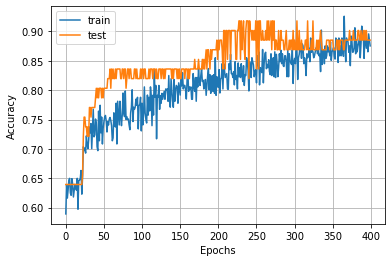

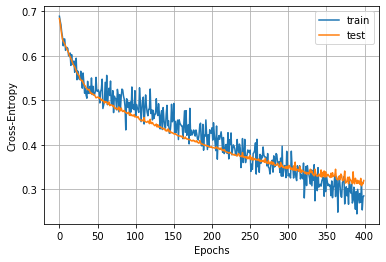


Iteration: 4
loss:  0.41542825591368754
accuracy:  0.8196721076965332
f1: 0.7927092987333951
confusion matrix:
 [[14  9]
 [ 2 36]]
AUC 0.9084668192219679


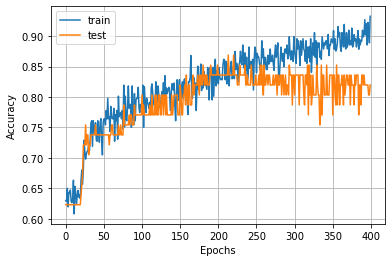

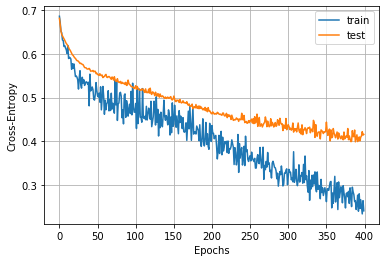


Iteration: 5
loss:  0.514106293519338
accuracy:  0.800000011920929
f1: 0.7619047619047619
confusion matrix:
 [[12 10]
 [ 2 36]]
AUC 0.8552631578947368


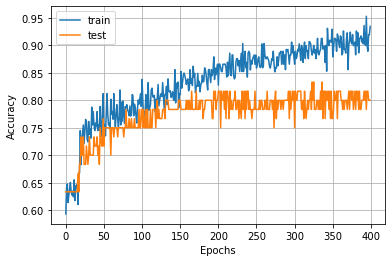

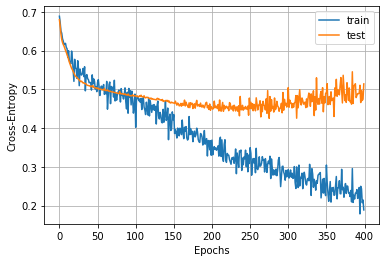


Resultados:
loss: [0.31339767013416914, 0.19300500364577183, 0.31983642744236307, 0.41542825591368754, 0.514106293519338]
accuracy: [0.8524590134620667, 0.9508196711540222, 0.8852459192276001, 0.8196721076965332, 0.800000011920929]
f1: [0.8383868118928466, 0.9471861471861471, 0.8788652482269504, 0.7927092987333951, 0.7619047619047619]
auc: [0.9335664335664335, 0.9836829836829837, 0.9312354312354313, 0.9084668192219679, 0.8552631578947368]
Tiempo: 405.20502376556396


In [19]:
# data augmentation
'''inicio = time.time()
array_loss = []
array_acc = []
array_f1 = []
array_auc = []
i = 0
for iTrain, jTest in skf.split(x, y):
  print("\nIteration:", i + 1)
  x_train, x_test = x[iTrain], x[jTest]
  y_train, y_test = y[iTrain], y[jTest]
  y_train_categorical, y_test_categorical = y_categorical[iTrain], y_categorical[jTest]

  model = CNN_2D()
  
  history = model.fit_generator(datagen.flow(x_train, y_train_categorical, batch_size=18),
                                steps_per_epoch=np.ceil(n_samples/18),
                                epochs=400,
                                validation_data=(x_test, y_test_categorical),
                                verbose=0) #callbacks=[mc])
  
  test_loss, test_acc = model.evaluate(x_test, y_test_categorical, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  f1 = f1_score(y_test, y_pred, average='macro')
  array_f1.append(f1)
  print("f1:", f1)
  
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)

  probabilidades = probabilidades[:, 1]
  auc = roc_auc_score(y_test, probabilidades)
  fpr, tpr, thresholds = roc_curve(y_test, probabilidades)
  array_auc.append(auc)

  print("AUC", auc)
  #plt.plot(fpr, tpr)
  #plt.grid()
  #plt.xlabel('False Positive Rate')
  #plt.ylabel('True Positive Rate')
  #plt.show()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
  i += 1
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("f1:", array_f1)
print("auc:", array_auc)
fin = time.time()
print("Tiempo:", fin - inicio)'''

In [17]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 352, 4, 16)        160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 176, 2, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 176, 2, 16)        2320      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 88, 1, 16)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1408)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                90176     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)               

In [18]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean F1: %.4f" % np.mean(array_f1))
print("std: (+/- %.4f)" % np.std(array_f1))
print("Mean auc: %.4f" % np.mean(array_auc))
print("std: (+/- %.4f)" % np.std(array_auc))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max F1: %.4f" % np.max(array_f1))
print("Max auc: %.4f" % np.max(array_auc))

Mean Accuracy: 0.8158
std: (+/- 0.0482)
Mean F1: 0.7990
std: (+/- 0.0533)
Mean auc: 0.9055
std: (+/- 0.0347)
Max Accuracy: 0.8756
Max F1: 0.8635
Max auc: 0.9468


In [20]:
#400 iteraciones todo(75.78)   dropout 0.5(75.46)
# 01ACLL-1 = 80.93%        (80.41)
# 03ATH-3 = 71.02%         (70.84)
# 08GMS-3 = 70.16%         (71.50)
# 15RMFH-3 = 81.01%        (79.07)

#400 iteraciones centrales y parietales(69.76)
# 01ACLL-1 = 79.76
# 03ATH-3 = 63.81
# 08GMS-3 = 59.51
# 15RMFH-3 = 75.97

# Data Augmentation(74.71)
# 01ACLL-1 = 75.97
# 03ATH-3 = 69.48
# 08GMS-3 = 70.92
# 15RMFH-3 = 82.45

# Data Augmentation centrales y parietales(71.54)
# 01ACLL-1 = 79.31
# 03ATH-3 = 67.80
# 08GMS-3 = 61.82
# 15RMFH-3 = 77.21

# Resize 352x10 (74.37) [72.22]
# 01ACLL-1 = 79.73 [77.92]
# 03ATH-3 = 75.76  [72.77]
# 08GMS-3 = 70.43  [68.78]
# 12MMA-1 = 62.91  [61.75]
# 15RMFH-3 = 83.00 [79.86]

#----------Este es el bueno----------
# Resize 352x5 quitar una CNN y pool (73.64) [72.75]
# 01ACLL-1 = 78.92 [77.49]
# 03ATH-3 = 73.17  [73.16]
# 08GMS-3 = 74.34  [74.15]
# 12MMA-1 = 58.90  [57.07]
# 15RMFH-3 = 82.86 [81.88]

# Resize 352x5 quitar una CNN y pool centraes y parietales(69.88)
# 01ACLL-1 = 79.64
# 03ATH-3 = 64.46
# 08GMS-3 = 60.18
# 15RMFH-3 = 75.25

# Resize 352x5 quitar una CNN y pool con data augmentation(75.34)
# 01ACLL-1 = 76.52
# 03ATH-3 = 67.21
# 08GMS-3 = 71.79
# 15RMFH-3 = 85.84

# Ventaneo (76.15)
# 01ACLL-1 = 75.50
# 03ATH-3 = 76.22
# 08GMS-3 = 72.99
# 15RMFH-3 = 79.90

# Por ultimo probar la CNN de BCI IV-2a